# Getting a Feeling how frequency shifts effect the ratio.

You put in some values for your ions and check out what common absolute or relative shifts on the measured frequency effect your ratio.

In [32]:
import scipy.constants as cont
import numpy as np
from scipy.fft import fft, fftfreq

import copy
import pandas as pd
from uncertainties import ufloat, unumpy
from uncertainties.umath import *

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
%matplotlib inline

%load_ext autoreload
%autoreload 2

m_e = cont.physical_constants["electron mass in u"] # error is 3e-11
m_e = ufloat(m_e[0], m_e[2])
ukg = cont.physical_constants["atomic mass unit-kilogram relationship"][0]
e = cont.physical_constants["elementary charge"] # error is 3e-11
e = ufloat(e[0], e[2])

from fticr_toolkit import ame
from fticr_toolkit import ideal_trap_physics as ideal
from fticr_toolkit import systematics as sys_fun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
example_ratios = [('172Yb43+', '168Yb42+'), ('172Yb43+', '176Yb44+'), ('172Yb42+', '168Yb42+'), 
                  ('172Yb42+', '170Yb42+'), ('172Yb42+', '174Yb42+'), ('172Yb42+', '176Yb42+'), 
                  ('172Yb41+', '172Yb42+'), ('172Yb42+', '172Yb43+')] #, ('172Yb42+', '12C3+')

nu_res = 700e3

for ions in example_ratios:
    try:
        m1, dm1, data = ame.get_ion_mass(ion=ions[0], binding=None, full=True, show=False, debug = False)
        q1 = data['q']
        qm1 = q1/m1*e/ukg
        omc, omp, omz, omm, p, z, m = ideal.ion_stats(ions[0], nures=nu_res, U0=None, nominal=True)
        nuc1 = omc/2/np.pi
        nuz1 = omz/2/np.pi
        U01 = ideal.U0(q1, m1, nu_res)
        
        # same nu_res
        m2, dm2, data = ame.get_ion_mass(ion=ions[1], binding=None, full=True, show=False, debug = False)
        q2 = data['q']
        qm2 = q2/m2*e/ukg
        omc, omp, omz, omm, p, z, m = ideal.ion_stats(ions[1], nures=nu_res, U0=None, nominal=True)
        nuc2 = omc/2/np.pi
        nuz2 = omz/2/np.pi
        U02 = ideal.U0(q2, m2, nu_res)
        print(nuz1-nuz2)
        
        # same U0
        omc, omp, omz, omm, p, z, m = ideal.ion_stats(ions[1], nures=None, U0=U01, nominal=True)
        nuc3 = omc/2/np.pi
        nuz3 = omz/2/np.pi

        R1 = qm1/qm2-1
        dU0 = U02 - U01
        dnuz = nuz1 - nuz3
        
        print(">>>", ions, R1, dU0, dnuz)
        
    except:
        raise
        print(ions, 'failed')
        continue
  


0.0
>>> ('172Yb43+', '168Yb42+') (-2.3687927499183026+/-0)e-05 0.0006345996735817039 -8.290921921143308
0.0
>>> ('172Yb43+', '176Yb44+') (4.360374667800038+/-0)e-05 -0.0011681445499753806 15.260812267661095
0.0
>>> ('172Yb42+', '168Yb42+') -0.02328204674039369+/-0 0.6385787724477012 -8293.82355020428
0.0
>>> ('172Yb42+', '170Yb42+') -0.01164318570043077+/-0 0.3193486945055426 -4111.049314191798
0.0
>>> ('172Yb42+', '174Yb42+') 0.011648196822882317+/-0 -0.31948613931266223 4041.5949922300642
0.0
>>> ('172Yb42+', '176Yb42+') 0.023303526714739897+/-0 -0.6391679240718346 8016.39559236588
0.0
>>> ('172Yb41+', '172Yb42+') -0.023812626434070006+/-0 0.6690636475111624 -8486.284177739872
0.0
>>> ('172Yb42+', '172Yb43+') -0.023258909768262837+/-0 0.6379441727741195 -8285.43449415383


## Getting a feeling - Illustration of uncertainties due to 

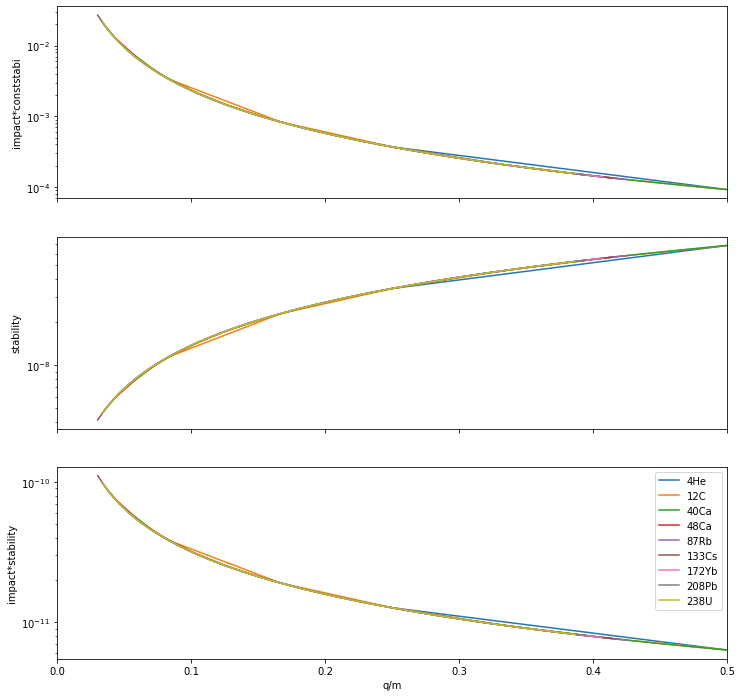

In [3]:
example_isotopes = ['4He', '12C', '40Ca', '48Ca', '87Rb', '133Cs', '172Yb', '208Pb', '238U']

absolute_stability = 1e-6# Volt
nu_res = 730e3

f, axs = plt.subplots(3, sharex=True, figsize=(12, 12))

example_ions = {}
for iso in example_isotopes:
    try:
        _, _, data = ame.get_ion_mass(ion=iso+'1+', binding=None, full=True, show=False, debug = False)
        Z, A, mneutral = data['Z'], data['A'], data['mneutral'].n
        q = np.arange(1, Z+1)
        m = mneutral - q*m_e.n # good enough
        #print(m)
        qm = q/m 
        mask = qm < 0.03
        qm[mask] = None
        m[mask] = None
        #q[mask] = None
               
        omegac = ideal.omegac(q, m, B=7)
        #print(omegac)
        omegaz = nu_res*2*np.pi
        omegap = ideal.omegap(omegac, omegaz, nominal=False)
        impact = 1/2*omegaz**2/omegap**2
        
        U0 = ideal.U0(q, m, nu_res, c2=-1.496e4)
        stability = absolute_stability/abs(U0)
    
    except:
        raise
        print(iso, 'failed')
        continue
        
    #print(impact)
    axs[0].plot(qm, impact, label=iso)
    axs[1].plot(qm, stability, label=iso)
    axs[2].plot(qm, stability*impact, label=iso)

axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[2].set_yscale('log')

axs[0].set_ylabel('impact*conststabi')
axs[1].set_ylabel('stability')
axs[2].set_ylabel('impact*stability')
axs[2].set_xlabel('q/m')
axs[2].set_xlim(0, 0.5)


plt.legend()
plt.show()
    


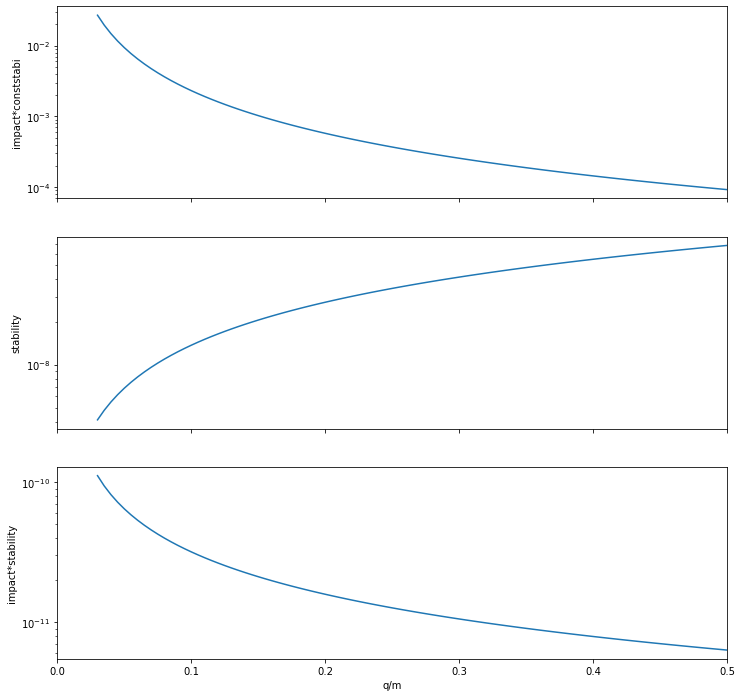

In [4]:

absolute_stability = 1e-6# Volt
nu_res = 730e3

f, axs = plt.subplots(3, sharex=True, figsize=(12, 12))

try:
    mneutral = 200
    q = np.arange(1, 101)
    m = mneutral - q*m_e.n # good enough
    #print(m)
    qm = q/m 
    mask = qm < 0.03
    qm[mask] = None
    m[mask] = None
    #q[mask] = None

    omegac = ideal.omegac(q, m, B=7)
    #print(omegac)
    omegaz = nu_res*2*np.pi
    omegap = ideal.omegap(omegac, omegaz, nominal=False)
    impact = 1/2*omegaz**2/omegap**2

    U0 = ideal.U0(q, m, nu_res, c2=-1.496e4)
    stability = absolute_stability/abs(U0)

except:
    raise

#print(impact)
axs[0].plot(qm, impact)
axs[1].plot(qm, stability)
axs[2].plot(qm, stability*impact)

axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[2].set_yscale('log')

axs[0].set_ylabel('impact*conststabi')
axs[1].set_ylabel('stability')
axs[2].set_ylabel('impact*stability')
axs[2].set_xlabel('q/m')
axs[2].set_xlim(0, 0.5)

plt.show()
    


axial stability 2.0547945205479452e-08
470000.0 132Xe18+ -22.13533187552609 4.517664364028122e-08 18554856.274047993 0.010616511255466088
132Xe18+ 0.13647293429162402 0.0005137594896808123 4.517664364028122e-08
470000.0 158Gd24+ -19.876210127167433 5.031140210342053e-08 18554856.274047993 0.011823179494303825
158Gd24+ 0.1519843910506328 0.0004141603027454915 5.031140210342053e-08
470000.0 187Re29+ -19.473161770347126 5.135272904283864e-08 18554856.274047993 0.012067891325067082
187Re29+ 0.15513010820728745 0.0003975207535861679 5.135272904283864e-08
470000.0 163Dy26+ -18.928618349541445 5.283005772178958e-08 18554856.274047993 0.012415063564620552
163Dy26+ 0.15959293154881246 0.00037558275692101367 5.283005772178958e-08
470000.0 172Yb42+ -12.364966860745685 8.087364982551144e-08 18554856.274047993 0.019005307708995188
172Yb42+ 0.24430908118016462 0.0001602015455919894 8.087364982551144e-08
470000.0 12C3+ -12.081837669970678 8.276886574014257e-08 18554856.274047993 0.019450683448933505


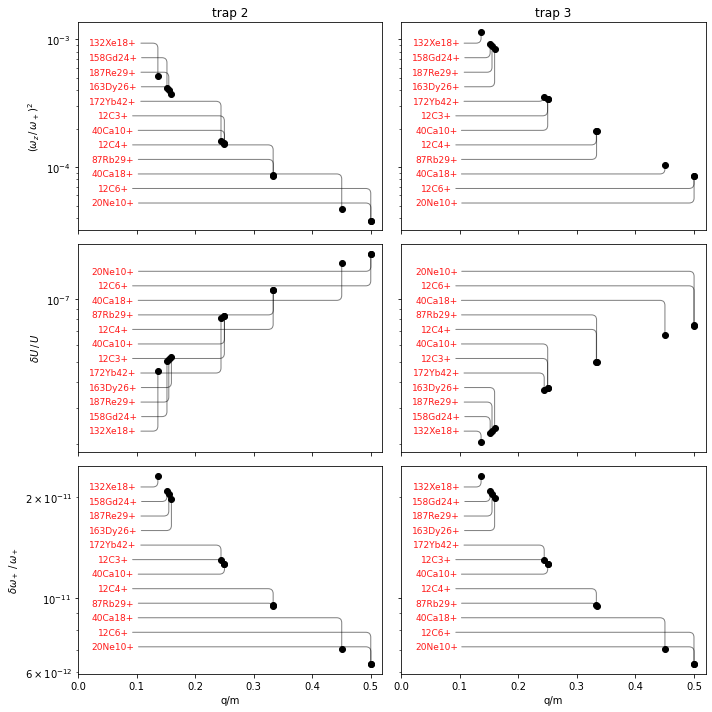

In [30]:
example_isotopes = ['4He', '12C', '40Ca', '48Ca', '87Rb', '133Cs', '172Yb', '208Pb', '238U']
example_ions = ['132Xe18+', '158Gd24+', '187Re29+', '163Dy26+', '172Yb42+', '12C3+', '40Ca10+', 
                '12C4+', '87Rb29+', '40Ca18+', '12C6+', '20Ne10+']#, '4He2+']

#stability = np.logspace(1e-9, 1e-6, num=100, endpoint=True)
absolute_stability = 1000e-9# Volt # DAC 100nV * 10
nu_res = 730e3
dnuznuz = 15e-3/nu_res
dUU = 100e-9
B0 = 7
#dnuznuz = dUU/2

print('axial stability', dnuznuz)

bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle="-",
    alpha=0.5,
    connectionstyle="angle,angleA=0,angleB=90,rad=5")

f, axs = plt.subplots(3, 2, sharex=True, sharey='row', figsize=(10, 10))

for i, nu_res in enumerate([470e3, 700e3]):
    for j, ion in enumerate(example_ions):
        try:
            m, _, data = ame.get_ion_mass(ion=ion, binding=None, full=True, show=False, debug = False)
            q = data['q']
            qm = q/m
            #print(qm)

            omegac = ideal.omegac(q, m, B=B0)
            omegaz = nu_res*2*np.pi
            omegap = ideal.omegap(omegac, omegaz, nominal=False)
            impact = 1/2*omegaz**2/omegap**2

            U0 = ideal.U0(q, m, nu_res, c2=-1.496e4)
            stability = absolute_stability/abs(U0)
            delnuz = stability*omegaz/2/2/np.pi
            delnuzdip = dnuznuz
            print(nu_res, ion, U0, stability, omegaz*2*np.pi, delnuz)

        except:
            raise
            print(iso, 'failed')
            continue

        print(ion, qm, impact, stability)
        #print(impact)
        axs[0,i].plot(qm, impact, "o", label=ion, color='k')
        axs[1,i].plot(qm, stability, "o",  label=ion, color='k')
        axs[2,i].plot(qm, stability*impact, "o",  label=ion, color='k')
        #axs[1,i].plot(qm, dnuznuz, "o",  label=ion, color='k', alpha=0.3)
        #axs[2,i].plot(qm, dnuznuz*impact, "o",  label=ion, color='k', alpha=0.3)
        ax = axs[0,i]
        tform = blended_transform_factory(ax.transData, ax.transAxes)
        ax.annotate(ion, xy=(qm, impact), xycoords='data', 
            xytext=(0.06, 0.9-(j*0.07)), textcoords=tform, fontsize=9,
            ha='center', va='center', color='r', arrowprops=arrowprops, alpha=0.9)
        ax = axs[1,i]
        tform = blended_transform_factory(ax.transData, ax.transAxes)
        ax.annotate(ion, xy=(qm, stability), xycoords='data', 
            xytext=(0.06, 0.1+(j*0.07)), textcoords=tform, fontsize=9,
            ha='center', va='center', color='r', arrowprops=arrowprops, alpha=0.9)
        ax = axs[2,i]
        tform = blended_transform_factory(ax.transData, ax.transAxes)
        ax.annotate(ion, xy=(qm, stability*impact), xycoords='data', 
            xytext=(0.06, 0.9-(j*0.07)), textcoords=tform, fontsize=9,
            ha='center', va='center', color='r', arrowprops=arrowprops, alpha=0.9)

    axs[0,i].set_yscale('log')
    axs[1,i].set_yscale('log')
    axs[2,i].set_yscale('log')

    axs[0,0].set_ylabel(r'$({\omega_z}\,/\, {\omega_+})^2$')
    axs[1,0].set_ylabel(r'${\delta U}\,/\, {U}$')
    axs[2,0].set_ylabel(r'${\delta \omega_+}\,/\, {\omega_+}$')
    axs[2,i].set_xlabel('q/m')
    axs[2,i].set_xlim(0, 0.52)
    axs[0,i].set_title("trap "+str(i+2))

plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.tight_layout()
plt.savefig("unoise_impact_ions.pdf", dpi=100)#, patch=0.5)
#plt.legend()
plt.show()
    


axial stability 1.3698630136986301e-08
132Xe18+ 0.13647293429162402 0.0010275189793616246 2.258832182014061e-08
158Gd24+ 0.1519843910506328 0.000828320605490983 2.5155701051710264e-08
187Re29+ 0.15513010820728745 0.0007950415071723358 2.567636452141932e-08
163Dy26+ 0.15959293154881246 0.0007511655138420273 2.641502886089479e-08
172Yb42+ 0.24430908118016462 0.0003204030911839788 4.043682491275572e-08
12C3+ 0.25003428907841746 0.00030589366023348464 4.1384432870071284e-08
40Ca10+ 0.2502683744888273 0.00030532152552933457 4.142317752380927e-08
12C4+ 0.33339429338871246 0.00017202642465997993 5.518176648836674e-08
87Rb29+ 0.3337426722918062 0.00017166740924840987 5.523942843298071e-08
40Ca18+ 0.4505324741395263 9.419448736206725e-05 7.456989599521194e-08
4He2+ 0.4998117984753786 7.65344578791513e-05 8.272636484345036e-08
12C6+ 0.5001371365020074 7.643491168762403e-05 8.278021317670389e-08
20Ne10+ 0.5003262590981555 7.637713362585603e-05 8.281151580888825e-08
132Xe18+ 0.13647293429162402 0.

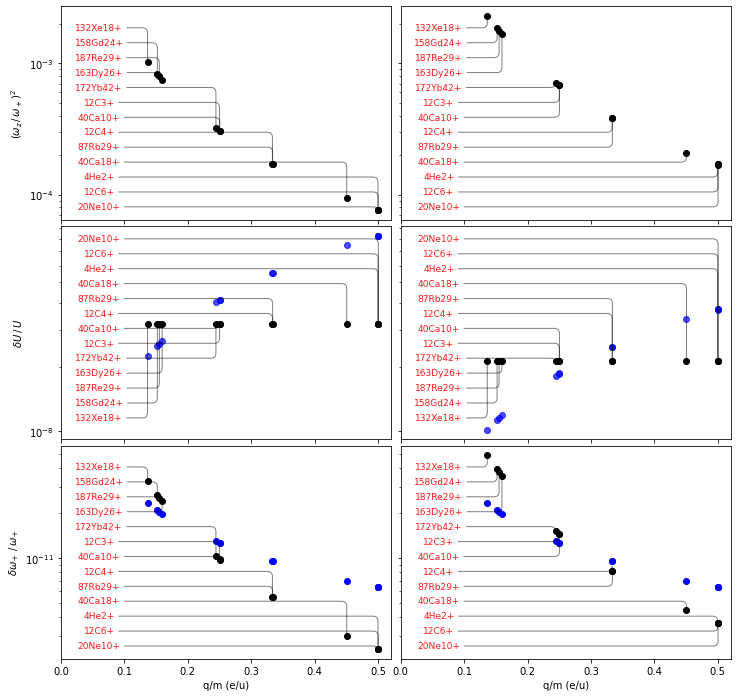

In [13]:
example_isotopes = ['4He', '12C', '40Ca', '48Ca', '87Rb', '133Cs', '172Yb', '208Pb', '238U']
example_ions = ['132Xe18+', '158Gd24+', '187Re29+', '163Dy26+', '172Yb42+', '12C3+', '40Ca10+', 
                '12C4+', '87Rb29+', '40Ca18+', '4He2+', '12C6+', '20Ne10+']

#stability = np.logspace(1e-9, 1e-6, num=100, endpoint=True)
absolute_stability = 1000e-9# Volt # DAC 100nV * 10
nu_res = 730e3
dnuznuz = 10e-3/nu_res
dUU = 100e-9
B0=7
#dnuznuz = dUU/2

print('axial stability', dnuznuz)

bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle="-",
    alpha=0.5,
    connectionstyle="angle,angleA=0,angleB=90,rad=5")

f, axs = plt.subplots(3, 2, sharex=True, sharey='row', figsize=(12, 12))

for i, nu_res in enumerate([470e3, 700e3]):
    for j, ion in enumerate(example_ions):
        try:
            m, _, data = ame.get_ion_mass(ion=ion, binding=None, full=True, show=False, debug = False)
            q = data['q']
            qm = q/m
            #print(qm)

            omegac = ideal.omegac(q, m, B=B0)
            omegaz = nu_res*2*np.pi
            omegap = ideal.omegap(omegac, omegaz, nominal=False)
            impact = omegaz**2/omegap**2

            U0 = ideal.U0(q, m, nu_res, c2=-1.496e4)
            stability = absolute_stability/abs(U0)*1/2
            dnuznuz = 15e-3/nu_res

        except:
            raise
            print(iso, 'failed')
            continue

        print(ion, qm, impact, stability)
        #print(impact)
        axs[0,i].plot(qm, impact, "o", label=ion, color='k')
        axs[1,i].plot(qm, stability, "o", color='b', alpha=0.7)
        axs[1,i].plot(qm, dnuznuz, "o",  label=ion, color='k')
        axs[2,i].plot(qm, stability*impact, "o", color='b')
        axs[2,i].plot(qm, dnuznuz*impact, "o",  label=ion, color='k')
        ax = axs[0,i]
        tform = blended_transform_factory(ax.transData, ax.transAxes)
        ax.annotate(ion, xy=(qm, impact), xycoords='data', 
            xytext=(0.06, 0.9-(j*0.07)), textcoords=tform, fontsize=9,
            ha='center', va='center', color='r', arrowprops=arrowprops, alpha=0.9)
        ax = axs[1,i]
        tform = blended_transform_factory(ax.transData, ax.transAxes)
        ax.annotate(ion, xy=(qm, dnuznuz), xycoords='data', 
            xytext=(0.06, 0.1+(j*0.07)), textcoords=tform, fontsize=9,
            ha='center', va='center', color='r', arrowprops=arrowprops, alpha=0.9)
        ax = axs[2,i]
        tform = blended_transform_factory(ax.transData, ax.transAxes)
        ax.annotate(ion, xy=(qm, dnuznuz*impact), xycoords='data', 
            xytext=(0.06, 0.9-(j*0.07)), textcoords=tform, fontsize=9,
            ha='center', va='center', color='r', arrowprops=arrowprops, alpha=0.9)

    axs[0,i].set_yscale('log')
    axs[1,i].set_yscale('log')
    axs[2,i].set_yscale('log')

    axs[0,0].set_ylabel(r'$({\omega_z}\,/\, {\omega_+})^2$')
    axs[1,0].set_ylabel(r'${\delta U}\,/\, {U}$')
    axs[2,0].set_ylabel(r'${\delta \omega_+}\,/\, {\omega_+}$')
    axs[2,i].set_xlabel('q/m (e/u)')
    axs[2,i].set_xlim(0, 0.52)

plt.subplots_adjust(wspace=0.03, hspace=0.03)
#plt.legend()
plt.show()
    


In [6]:
example_ions = ['4He2+', '12C6+', '187Re29+', '172Yb42+', '87Rb29+', '40Ca10+']

#stability = np.logspace(1e-9, 1e-6, num=100, endpoint=True)
stability = [1e-8, 5e-8, 10e-8] #
nu_res = 600e3
dnuznuz = 20e-3/nu_res
dUU = 5e-8
#dnuznuz = dUU/2
print('axial stability', dnuznuz)

example_ions = {}
for iso in example_isotopes:
    try:
        _, _, data = ame.get_ion_mass(ion=iso+'1+', binding=None, full=True, show=False, debug = False)
        Z, A, mneutral = data['Z'], data['A'], data['mneutral'].n
        q = np.arange(1, Z+1)
        m = mneutral - q*m_e.n # good enough
        print(m)
        qm = q/m 

        omegac = ideal.omegac(q, m, B=7)
        #print(omegac)
        omegaz = nu_res*2*np.pi
        omegap = ideal.omegap(omegac, omegaz, nominal=False)
        impact = 1/2*omegaz**2/omegap**2
    
    except:
        print(iso, 'failed')
        continue
        
    #print(impact)
    plt.plot(qm, stability*impact, label=iso)


plt.yscale('log')
plt.legend()
plt.show()
    


axial stability 3.3333333333333334e-08
[4.00205467 4.00150609]


ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [ ]:
example_isotopes = ['4He', '12C', '40Ca', '48Ca', '87Rb', '133Cs', '172Yb', '208Pb', '238U']

#stability = np.logspace(1e-9, 1e-6, num=100, endpoint=True)
stability = 2e-8#

example_ions = {}
for iso in example_isotopes:
    try:
        _, _, data = ame.get_ion_mass(ion=iso+'1+', binding=None, full=True, show=False, debug = False)
        Z, A, mneutral = data['Z'], data['A'], data['mneutral'].n
        q = np.arange(1, Z+1)
        m = mneutral - q*m_e.n # good enough
        print(m)
        qm = q/m 

        omegac = ideal.omegac(q, m, B=7)
        #print(omegac)
        omegaz = 600e3*2*np.pi
        omegap = ideal.omegap(omegac, omegaz, nominal=False)
        impact = 1/2*omegaz**2/omegap**2
    
    except:
        print(iso, 'failed')
        continue
        
    #print(impact)
    plt.plot(qm, stability*impact, label=iso)


plt.yscale('log')
plt.legend()
plt.show()
    


### SAME ABSOLUTE OFFSET ON BOTH FREQUENCIES
1) What happens when both frequencies get an constant offset?

R' = omegaA'/omegaB' = ( omegaA + c ) / ( omegaB + c )

dR = R - R' = omegaA/omegaB - ( omegaA + c ) / ( omegaB + c )

In [ ]:
def dR1(c, R):
    return omegaA/omegaB - ( omegaA + c ) / ( omegaB + R*c )
c = np.logspace(-1, 3, 100) # 100mHz to 10kHz
plt.plot(c/omegaA, dR1(c, R))
plt.title('$\Delta$R vs. $c/\omega_A$, same constant offset $c$')
plt.xlabel('$c/\omega_A$ (1)')
plt.ylabel('$\Delta$R (1)')
plt.show()
plt.plot(c, dR1(c, R))
plt.title('$\Delta$R vs. $c$, same constant offset $c$')
plt.xlabel('$c$ (Hz)')
plt.ylabel('$\Delta$R (1)')
plt.show()

This shows that for a systematic constant offset for both frequencies, the ratio is 
basically uneffected (<1e-12) for c < 1kHz .

An example for this is basically every shift we get when looking at the absolute value of the
shift. E.g. the relativistic shifts can be pretty high, but as shown doesn't really matter
if they are exactly the same for both ions. This is obviously not true since the masses are
different, but we don't have to panic because the absolute value is high, we just have to check
what the difference in these shifts are for the two ions. See below. 

### SAME RELATIVE OFFSET ON BOTH FREQUENCIES
2) What happens when both frequencies get an relative shift?

If we get an offset on both frequencies which is defined by a constant * omega_c (a relative offset)
the frequency ratio is not effected, easily shown mathematically:

R'  = omegaA' / omegaB' 

    = ( omegaA + omegaA*c ) / ( omegaB + omegaB*c )

    = R (1+c)/(1+c)
    
    = R

An example for this kind of relative offset is the deviation of the 10 MHz standard
from true 10 MHz: If the rubidium standards is off by a relative factor of e.g. 1e-4 (so 1 kHz)
the measured frequencies get the same relative error (even in pnp due to the change in the
evolution time, please check again though ;) ).

### SINGLE ABSOLUTE OFFSET ON ONE FREQUENCY
 3) What happens when one frequency gets an offset? (This is 
 what basically happens for example in the naive method: one
 of the two frequencies always gets an offset due to the linear
 drift of the magnetic field)

R' = omegaA' / omegaB' 

    = ( omegaA + c ) / ( omegaB)

dR = R - R' = omegaA / omegaB - ( omegaA + c ) / ( omegaB )
    
    = - c / omegaB

In [ ]:
def dR3(c):
    return -c / ( omegaB )
c = np.logspace(-7, -5, 1000) # 1uHz to 0.1mHz
plt.plot(c/omegaB, dR3(c))
plt.title('$\Delta$R vs. $c/\omega_B$, single offset $c$')
plt.xlabel('$c/\omega_A$ (1)')
plt.ylabel('$\Delta$R (1)')
plt.show()
plt.plot(c, dR3(c))
plt.title('$\Delta$R vs. $c$, single offset $c$')
plt.xlabel('$c$ (Hz)')
plt.ylabel('$\Delta$R (1)')
plt.show()

For a systematic constant offset for one frequency, the ratio is very sensitive. 
To continue the example before, lets consider a drift of the 10 MHz standard, the values given in the data sheet of the SRS FS725 are:

<2×10–11 (1s)

<1×10–11 (10s)

<2×10–12 (100s)

Since we don't see a particulary high phase fluctuation (10-20 degree std) compared to the 
linear drift of the cyclotron frequency (both could be magnetic field AND/OR the 10 MHz standard!),
lets consider for a 10 Minute gap between two different ions measurements a conservative shift of
1e-12. This would result in this example of a pretty much perfect doublet to a ratio
offset of the same scale. One short remark to this specific example: This effect is 
as mentioned before equal to the magnetic field drift. As long as short term fluctuations
don't mess up our phase stability, this effect is basically fitted along with magnetic field
drifts in the polynom fit method and also in the comparison of the naive ratios determined
by measurements with different order in time ( Re/Os and Os/Re ). TODO: Something I did not yet
calculate directly, is the impact when using the cancellation methd. But from the basic idea of
the cancellation method, short time fluctuations should be cancelled out, long term have the
same offset effect as the naive method.

Another example would be different offsets due to different shifts of typical Penning trap
systematics, e.g. C4/C6, B2, B1C1, relativistic shift, image charge shift. Both ions are
exposed to these shifts, which could for a single ion frequency be in the range of multiple
Hz or more, but the important questions is what is the difference in the shifts for the two
ions measured.

Looking at the difference of the absolute shifts neccessary to create meaningfull offsets in
the ratio (lower plot), we see that already a shift of 50 uHz is a problem for the ratio,
something we could never observe directly in frequency measurements. We try to estimate 
these shifts using characterization measurements where we amplify these effects, typically 
by increasing the ion radius or detune the trap or both and extrapolate/interpolate to
measurement settings. These effects will be analysed in the following, given trap parameters
measured in mentioned characterization measurements.

In [ ]:
print("\n### BOTH EFFECTS IN A HEAT MAP")
# 3) What happens when both frequencies get different offsets
def dR4(cA, cB):
    return omegaA/omegaB - ( omegaA + cA ) / ( omegaB + cB )
# generate 2 2d grids for the x & y bounds
cA, cB = np.meshgrid( np.linspace(1e-6, 1e-3, 100), np.linspace(1e-6, 1e-3, 100) )
dR = dR4(cA, cB)

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
dR = dR[:-1, :-1]
z_min, z_max = -np.abs(dR).max(), np.abs(dR).max()

fig, ax = plt.subplots()
crange = 1e-12
c = ax.pcolormesh(cA, cB, dR, cmap='RdBu', vmin=-crange, vmax=crange)
ax.set_title('$\Delta$R vs. different offsets $\omega_{c,A/B}$')
# set the limits of the plot to the limits of the data
ax.axis([cB.min(), cB.max(), cA.min(), cA.max()])
fig.colorbar(c, ax=ax)
plt.show()
fig, ax = plt.subplots()
crange = 1e-11
c = ax.pcolormesh(cA, cB, dR, cmap='RdBu', vmin=-crange, vmax=crange)
ax.set_title('$\Delta$R vs. different offsets $\omega_{c,A/B}$')
# set the limits of the plot to the limits of the data
ax.axis([cB.min(), cB.max(), cA.min(), cA.max()])
fig.colorbar(c, ax=ax)
plt.show()
fig, ax = plt.subplots()
crange = 1e-10
c = ax.pcolormesh(cA, cB, dR, cmap='RdBu', vmin=-crange, vmax=crange)
ax.set_title('$\Delta$R vs. different offsets $\omega_{c,A/B}$')
# set the limits of the plot to the limits of the data
ax.axis([cB.min(), cB.max(), cA.min(), cA.max()])
fig.colorbar(c, ax=ax)
plt.show()

In [ ]:

# R = omegaB/omegaA = qB/qA * mA/mB * B/B
B0 = 7
ionA = '187Re29+'
ionB = '187Os29+'
ionA = '172Yb42+'
ionB = '176Yb42+'
isoA, elA, qA = ideal.re_ionstr(ionA)
isoB, elB, qB = ideal.re_ionstr(ionB)
#print(isoA, elA, qA)
mA, dmA = ame.get_ion_mass(ionA)
mB, dmB = ame.get_ion_mass(ionB)
R = mA/mB * qB/qA # = omegaB/omegaA -> omegaB = R*omegaA
omegaA = qA/mA *cont.e/1.661e-27* B0
omegaB = qB/mB *cont.e/1.661e-27* B0
print(omegaA/2/np.pi, R, omegaA*R/2/np.pi)
print(R-1)
def dRall(a, b, db):
    return omegaA*R/omegaA - ( omegaA*R*a + b*2*np.pi + db*2*np.pi) / ( omegaA*a + b*2*np.pi )#
    
b = np.logspace(-3, 0, 100)/1e3 #300mHz to 10kHz
db = b/1000

plt.plot(b, dRall(1, b, 0), label='b')
plt.plot(b, dRall(1, 0, db), label='db')
#plt.plot(b, dRall(1, b, db), label='b & db')
plt.title(r'$\Delta$R vs. freq shift')
plt.xlabel('shift value (Hz)')
plt.ylabel(r'$\Delta$R (1)')
plt.legend()
plt.grid(which='both')
plt.tight_layout()
plt.show()

degree = 6
tacc = 70
dnu = degree/360/70
print(dnu)

In [ ]:
# NEW
eVamu = ufloat(9.3149410242e8, 0.28)
print(eVamu.s/eVamu.n)
amueV = 1/eVamu
pi2 = 2*np.pi


In [ ]:
class IonStats():
    def __init__(self, ionstr, dm=None, U0=None, nu_res=None, B=7, delm=True):
        pi2 = 2*np.pi
        isoA, elA, qA = ideal.re_ionstr(ionstr)
        mA, dmA = ame.get_ion_mass(ionstr)
        mA = ufloat(mA, dmA)
        if not delm:
            mA = mA.n

        if dm is not None:
            mA2 = mA + dm*amueV.n
            mA = mA2
        self.m = mA
        #if not delm:
        #    self.m = self.m.n
        
        if nu_res is None and U0 is None:
            raise ValueError("U0 or nu_res has to be given")
        if nu_res is not None:
            self.nuz = nu_res
            self.U0 = ideal.U0(qA, self.m, nu_res)
        if U0 is not None:
            self.nuz = ideal.omegaz(qA, self.m, U0)/pi2
            self.U0 = U0

        self.nuc = ideal.omegac(qA, self.m, B=B)/pi2
        self.nup = ideal.omegap(self.nuc*pi2, self.nuz*pi2)/pi2
        self.num = ideal.omegam(self.nuc*pi2, self.nuz*pi2)/pi2
        
        self.nucside = ideal.omegac_sideband(self.nup*pi2, self.num*pi2)/pi2
        self.nucinv = ideal.omegac_invariance(self.nup*pi2, self.nuz*pi2, self.num*pi2)/pi2
    
class IonPair():
    def __init__(self, ionstrA, ionstrB, dmB=None, nures=500e3, delm=True):
        self.ionA = IonStats(ionstrA, nu_res=nures, delm=delm)
        self.ionB = IonStats(ionstrB, dm=dmB, U0=self.ionA.U0, delm=delm)
    
    def diffm(self):
        return (self.ionA.m - self.ionB.m)*eVamu
    
    def diffnuz(self):
        return self.ionA.nuz - self.ionB.nuz

    def diffnum(self):
        return self.ionA.num - self.ionB.num
    
    def diffnup(self):
        return self.ionA.nup - self.ionB.nup
    
    def diffnuc(self):
        return self.ionA.nuc - self.ionB.nuc
    
    def diffnucinv(self):
        return self.ionA.nucinv - self.ionB.nucinv
    
    def ratiodiff_inv(self, comoffnup = 0, comoffnuz = 0, comoffnum = 0, offnumB = 0, offnuzB=0, offnupB =0, offnumA = 0, offnuzA=0, offnupA =0):
        nupA, nuzA, numA = self.ionA.nup + comoffnup+offnupA, self.ionA.nuz + comoffnuz+offnuzA, self.ionA.num + comoffnum+offnumA
        nupB, nuzB, numB = self.ionB.nup + comoffnup+offnupB, self.ionB.nuz + comoffnuz+offnuzB, self.ionB.num + comoffnum+offnumB
        
        nucA = ideal.omegac_invariance(nupA*pi2, nuzA*pi2, numA*pi2)/pi2
        nucB = ideal.omegac_invariance(nupB*pi2, nuzB*pi2, numB*pi2)/pi2
        
        return nucA/nucB, nucA-nucB, nupA/nupB
    

In [ ]:
metaground = IonPair("208Pb40+", "208Pb40+", dmB=30, nures=500e3, delm=False)

print("diffnuc", metaground.diffnuc())
print("diffnup", metaground.diffnup())
print("diffnuz", metaground.diffnuz())
print("diffnum", metaground.diffnum())

In [ ]:
off = np.linspace(-1, 1, 100)*1e-4

cR, cD, pR = metaground.ratiodiff_inv()
print(cR - pR)

ratio, diffs, nupratio = metaground.ratiodiff_inv(offnuzB=off)
mean = np.mean(unumpy.nominal_values(ratio))

plt.plot(off, unumpy.nominal_values(ratio)-mean)
plt.show()

In [ ]:
off = np.linspace(-1, 1, 100)*1

cR, cD, pR = metaground.ratiodiff_inv()
print(cR - pR)

ratio, diffs, nupratio = metaground.ratiodiff_inv(offnumB=off)
mean = np.mean(unumpy.nominal_values(ratio))

plt.plot(off, unumpy.nominal_values(ratio)-mean)
plt.show()

In [ ]:
diffratio = ratio - nupratio

plt.plot(off, unumpy.nominal_values(diffratio))
plt.show()

In [ ]:
metaground = IonPair("12C6+", "20Ne10+", dmB=1e5, nures=500e3, delm=False)

print("diffnuc", metaground.diffnuc())
print("diffnup", metaground.diffnup())
print("diffnuz", metaground.diffnuz())
print("diffnum", metaground.diffnum()*1e6)

In [ ]:
for i in range(1, 36):
    
    m, _, data = ame.get_ion_mass(ion="87Kr"+str(i)+"+", binding=None, full=True, show=False, debug = False)
    q = data['q']
    qm_1 = q/m
    
    m, _, data = ame.get_ion_mass(ion="87Kr"+str(i+1)+"+", binding=None, full=True, show=False, debug = False)
    q = data['q']
    qm_2 = q/m
    #print(qm)

    dnuz = ideal.dnu_z(600e3, qm_1, qm_2)
    print(i, dnuz)